<a href="https://colab.research.google.com/github/cermegno/my-computer-vision/blob/main/pose-drone-control/arm_pose_drone_control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detect arm poses to control a drone
Notebook to detect arm poses to provide control commands to a drone

###Install Yolo
Start by installing the Python library Ultralytics. Its dependencies are also pulling other libraries we need,ex: OpenCV and MatPlotLib

In [ ]:
%pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.7 MB/s eta 0:00:00


Import it

In [58]:
import cv2
from ultralytics import YOLO

### Grab YOLO Pose model
Grab it and show the details of the model

In [59]:
model = YOLO("yolo11l-pose.pt")
model.info()

YOLO11l-pose summary: 372 layers, 26,169,836 parameters, 0 gradients, 91.0 GFLOPs


(372, 26169836, 0, 91.0235648)

###Build the function to analyze poses
Left/Right is detected when the wrist, elbow and shoulder are aligned

In [74]:
def analyze_pose(image_path):
    # Run inference
    results = model(image_path)

    for result in results:
        annotated_image = result.plot()

        # Check if any person was detected
        if result.keypoints is not None:
            # Get keypoints for the first person detected (index 0)
            kp = result.keypoints.xy[0].cpu().numpy()

            if len(kp) < 11: continue # Ensure we have enough points

            # COCO Keypoint Indices
            # Left: Shoulder=5, Elbow=7, Wrist=9
            # Right: Shoulder=6, Elbow=8, Wrist=10
            l_shoulder_y = kp[5][1]
            r_shoulder_y = kp[6][1]
            l_elbow_y = kp[7][1]
            r_elbow_y = kp[8][1]
            l_wrist_y = kp[9][1]
            r_wrist_y = kp[10][1]

            # Logic: If shoulder, elbow, wrist have a similar "y", it's "extended"
            # We use a tolerance of 30pixels
            l_y_coords = [l_shoulder_y, l_elbow_y, l_wrist_y]
            r_y_coords = [r_shoulder_y, r_elbow_y, r_wrist_y]
            is_l_aligned = max(l_y_coords) - min(l_y_coords) < 30
            is_r_aligned = max(r_y_coords) - min(r_y_coords) < 30

            # Determine Output. I should check also that both are not extended
            if is_l_aligned:
                detection = "RIGHT"
            elif is_r_aligned:
                detection = "LEFT"
            else:
                detection = "STOP"

            return detection, annotated_image


image 1/1 /content/left.png: 512x640 1 person, 1801.3ms
Speed: 7.4ms preprocess, 1801.3ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 640)
LEFT detected


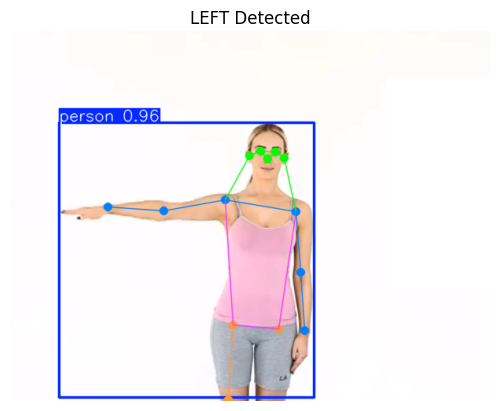

In [75]:
detection, annotated_image = analyze_pose(filename)
#detection, annotated_image = analyze_pose("right.png")
#detection, annotated_image = analyze_pose("stop.png")
print(f"{detection} detected")

plt.imshow(cv.cvtColor(annotated_image, cv.COLOR_BGR2RGB)) #OpenCV uses BGR
plt.title(f"{detection} Detected")
plt.axis('off')
plt.show()